# Test case definition: 

In this copy, we test the RBDO script for a thickness design space that is in inceament of 0.5 mm until 3.

In [1]:
filename = "Fx1k_Fy4k_Parallel_RBDO_P-0.005_pop100.txt"
threshold = 0.005 # to save in the text file
pareto_fig_name = "Fx1k_Fy4k_Pareto_RBDO100_threshold_0.005.png"

In [2]:
import openturns as ot
import openturns.viewer
import openturns.viewer as viewer
import numpy as np
import pandas as pd
from matplotlib import pylab as plt

ot.Log.Show(ot.Log.NONE)

The goal of this workflow is to develop two modules for the deterministic sizing exercise that needs to be performed, for which the reliability analysis shall be performed to calculate the probability of failure of the SDP clip.
- First, a quantile function shall be developed to calculate the A or B-basis of the probability distribution of the material properties & the limit loads (LL) of the static loading condition distribution.
- Second, a translator function shall be developed to translate the design variables (n_var = 4) obtained from the optimization process in pymoo, to the one usable for as input to the SDP clip analytical function. The translator shall retrieve all the inputs required for the SDP analytical function from the design variables and other variables are set to nominal (bolt location and pattern is fixed, we shall choose a straight line as our bolting line along X-axis)

# Quantile Function

In [3]:
#material property bounds for allowables: bearing allowable for clip is needed only for optimal sizing, and bolt allowables
#for tension and shear
"""LOADS INPUT DISTRIBUTION----------------------------------------------------------"""
#nominal input loads:
Fx = 1000
Fy = 4000

cov_load = 35/100 # 35 & 5 percent
cov_all = 5/100

#defined loading bounds (only needed when uniformly distributed):
#Fx_bound = (10/100) #%
#Fy_bound = (10/100) #%

"""SIGMA = Mean * Cov"""

#loads distributions:
applied_force_distribution = [ot.Normal(Fx, Fx*cov_load), ot.Normal(Fy, Fy*cov_load)]
#[ot.Uniform(-0.01 + Fx*(1-Fx_bound), 0.01 + Fx*(1+Fx_bound)), ot.Uniform(-0.01 + Fy*(1-Fy_bound), 0.01 + Fy*(1+Fy_bound))]


loadX_distribution = applied_force_distribution[0]
loadY_distribution = applied_force_distribution[1]

LLX = loadX_distribution.computeQuantile(1-(1/20000))[0]
LLY = loadY_distribution.computeQuantile(1-(1/20000))[0]
print("LLX for P: 1e-5 = ", (LLX))
print("LLY for P: 1e-5 = ", (LLY))

graph1 = loadX_distribution.drawPDF()
graph1.setColors(["blue"])
graph1.setLegends(["Fx"])

#view = viewer.View(graph1)

graph2 = loadY_distribution.drawPDF()
graph2.setXTitle("Loads applied")
graph2.setLegends(["Fy"])

graph2.add(graph1)
#view = viewer.View(graph2)


#graph2.setYTitle("PDF")
#graph2.setTitle("Probability density function of the standard gaussian distribution")


view = viewer.View(graph2)

LLX for P: 1e-5 =  2361.7071602446103
LLY for P: 1e-5 =  9446.828640978441


 # cov = 35%, Probability that an aircraft reaches LL in its lifetime = 1/20000 (Poccurence)

In [4]:
ULX = loadX_distribution.computeQuantile(1-(1e-9))[0]
ULY = loadY_distribution.computeQuantile(1-(1e-9))[0]
print("ULX for P: 1e-9 = ", (ULX))
print("ULY for P: 1e-9 = ", (ULY))
print("UL/LL X and Y: ", ULX/LLX, ULY/LLY)

# Typically UL/LL is 1.5. We should aim it to be higher from what we calculated!

ULX for P: 1e-9 =  3099.232456961247
ULY for P: 1e-9 =  12396.929827844988
UL/LL X and Y:  1.3122848205449182 1.3122848205449182


In [5]:
ULX2 = loadX_distribution.computeQuantile(1-(1e-12))[0]
ULY2 = loadY_distribution.computeQuantile(1-(1e-12))[0]
print("ULX2 for P: 1e-11 = ", (ULX2))
print("ULY2 for P: 1e-11 = ", (ULY2))
print("UL/LL X and Y: ", ULX2/LLX, ULY2/LLY)

# Typically UL/LL is 1.5. We should aim it to be higher from what we calculated!

ULX2 for P: 1e-11 =  3677.719832527344
ULY2 for P: 1e-11 =  14710.879330109376
UL/LL X and Y:  1.5572294035584113 1.5572294035584113


In [6]:
"""ALLOWABLES INPUT DISTRIBUTION----------------------------------------------------------"""
#allowable values input:
flat_ext_bearing_allowables_clip_frame_fuselage = np.array([750, 750, 750]).flatten()
flat_ext_shear_allowables_bolt = 600
flat_ext_tension_allowables_bolt = 800

#defined bounds:
#bolt_all_bound = 10/100 #%
#bearing_p1p2p3_bound = 10/100 #%

#defined distributions:
bearing_p123_allowables_distribution = [ot.Normal(k, k*cov_all) for k in flat_ext_bearing_allowables_clip_frame_fuselage.tolist()]
#[ot.Uniform(i*(1-bearing_p1p2p3_bound), i*(1+bearing_p1p2p3_bound)) for i in flat_ext_bearing_allowables_clip_frame_fuselage.tolist()]

shear_allowables_distribution = [ot.Normal(j, j*cov_all) for j in [flat_ext_shear_allowables_bolt]]
#[ot.Uniform(i*(1-bolt_all_bound), i*(1+bolt_all_bound)) for i in [flat_ext_shear_allowables_bolt]]

tension_allowables_distribution = [ot.Normal(i, i*cov_all) for i in [flat_ext_tension_allowables_bolt]]
#[ot.Uniform(i*(1-bolt_all_bound), i*(1+bolt_all_bound)) for i in [flat_ext_tension_allowables_bolt]]

#A-basis = 99%, B-basis = 90%

percentage = 90/100

#give the qualtile calculator a distribution, and the percentage at which it shall calculate the quantile
clip_allowables_distribution = bearing_p123_allowables_distribution[0] #we shall take only clip bearing
bolt_shear_allowables_distribution = shear_allowables_distribution
bolt_tension_allowables_distribution = tension_allowables_distribution



B_val_clip = clip_allowables_distribution.computeQuantile(percentage)[0]
B_val_bolt_shear = bolt_shear_allowables_distribution[0].computeQuantile(percentage)[0]
B_val_bolt_tension = bolt_tension_allowables_distribution[0].computeQuantile(percentage)[0]



print('B-basis of clip bearing allowable = ', (B_val_clip))
print('B-basis of bolt shear allowable = ', (B_val_bolt_shear))
print('B-basis of bolt tension allowable = ', (B_val_bolt_tension))


graph_clip_all = clip_allowables_distribution.drawPDF()
graph_clip_all.setColors(["green"])
graph_clip_all.setLegends(["Strength_br"])
graph_clip_all.add(graph2)



graph_b_shear = bolt_shear_allowables_distribution[0].drawPDF()
graph_b_shear.setColors(["black"])
graph_b_shear.setLegends(["Strength_bolt_shear"])

graph_clip_all.add(graph_b_shear)



graph_b_tension = tension_allowables_distribution[0].drawPDF()
graph_b_tension.setColors(["brown"])
graph_b_tension.setLegends(["Strength_bolt_tension"])

graph_clip_all.add(graph_b_tension)
view = viewer.View(graph_clip_all)

# yielding allowable, we use LL
# rupture allowable, we use UL
# check with Airbus folks for bolts, clip, check if we used UL or LL. UL is a stricter criteria.

B-basis of clip bearing allowable =  798.0581837079225
B-basis of bolt shear allowable =  638.446546966338
B-basis of bolt tension allowable =  851.262062621784


So, the above function from openturns allows for the computation of the quantile (x %) from a distribution we supply to it.
Okay, now that we have the qualtile calculator, we shall implement it on our two distributions: loads and material properties.
- loads, to calculate LL
- material properties, to calculate B-basis

What is a B-basis? It is the allowable value above which at least 90% of the population values will fall with 95% confidence levels.

Why B-basis? Because we have an assembly with redundant pathways, a fail-safe design, which means, if a member fails (eg a bolt), the loads get redistributed safely around the adjacent members (other bolts), so we can use B-basis as our allowable strength to size the structure deterministically. (Source: NIU Stress Analysis, Chapter 04)

Finally, above, we have the input block where distributions are defined with their bounds, for loads and material properties. Nothing shall change in this block. And then we have the qualtile calculator. This block calculates the LL from the loading distributions, and the B-basis for the clip bearing allowables only. 

# Translation & Assembly Process

Now, comes the translation process. What we shall develop here is a function or an algorithm that shall allow the retrieval of all the inputs of the SDP clip analytical (that long list!) from the design variable information from the pymoo optimal design process.
- What do we have from pymoo? The design variables: [nfw, nff, thickness, diameter]
- nfw and nff = number of fasteners in the web and foot respectively. We have nfw = NNinp and nff = NNinpfoot in our SDP code.
- thickness is for clip, which is part 1 as per definition, 2 and 3 are frame and fuselage skin resp. So we have tp1 = t 
- diameter is the diameter value of the bolt. Since we shall use all bolts of the same design and material, same bolts on web and foot, we have d = [diameter]*nfw and dfoot = [diameter]*nff

# Implementation of the Translator:
Converting pymoo optimal design point into openturns compatible input.

In [7]:
"""INPUT TRANSLATOR:"""
# x comes from pymoo!
from translator_module import translator
from sdp_clip_module_v2_updated import sdp_clip_analytical_function_v2
Fx_inp = LLX
Fy_inp = LLY

#fixed design parameters
length = 120 #parallel to the web
# e = 2.  #distance between holes and edges
# p = 2.  #distance between holes
web_height = 80 #vertical
foot_height = 70 #horizontal
density = 0.00000271 #kg/m3
all_frame_br = flat_ext_bearing_allowables_clip_frame_fuselage[1]
all_fuselage_br = flat_ext_bearing_allowables_clip_frame_fuselage[2]
bolt_K = 15
t_p2, t_p3 = 2, 3
# Loads input: LLX, LLY or ULX, ULY

def translated_model(x):
    SDP_Clip_Analytical_Inputs = translator(x, length, web_height, foot_height, Fx_inp, Fy_inp, B_val_clip , 
                                            B_val_bolt_shear, B_val_bolt_tension , 
                                            all_frame_br, all_fuselage_br, 
                                            bolt_K, t_p2, t_p3)
    # the translator throws out re-constructed inputs in the form of a list!
    RFs = sdp_clip_analytical_function_v2(SDP_Clip_Analytical_Inputs)
    # 
    return RFs, SDP_Clip_Analytical_Inputs

# Test Analytical Function, Translator(x) & Translated_model(x) with SDP Input

In [8]:
inputtemp = translated_model({'nfw': 4, 'dfw': 6.5, 'nff': 3, 't': 2})
print("inp1", inputtemp[0])
print("inp2", inputtemp[1])
print("============================================================================")


from sdp_clip_module_v2_printing_updated import sdp_clip_analytical_function_v2_printing
sdp_clip_analytical_function_v2_printing(inputtemp[1])

inp1 [5.898975181093333, 2.88875686617083, 2.7147991134704714, 26.911548899035264, 13.178716518514229, 18.577663115293138, 8.97044604737754]
inp2 [24,48,72,96,40,40,40,40,30,60,90,35,35,35,15,15,15,15,15,15,15,6.5,6.5,6.5,6.5,6.5,6.5,6.5,2,2,3,60,0,2361.71,9446.83,798.058,750,750,638.45,851.26,4,3]#42
locbvec [24. 48. 72. 96. 40. 40. 40. 40.]
foot_locbvec [30. 60. 90. 35. 35. 35.]
applied loads; Fxinp =  2361.7071602446103 Fyinp =  9446.828640978441
------------------------------------WEB--------------------------------------------
Stiffness Kb =  [15. 15. 15. 15.]
web LocF =  [60.  0.]
bolt_location_xi =  [24. 48. 72. 96.]
bolt_location_yi =  [40. 40. 40. 40.]
locbTT  [[24. 48. 72. 96.]
 [40. 40. 40. 40.]]
bolt locations =  [[24. 40.]
 [48. 40.]
 [72. 40.]
 [96. 40.]] <class 'numpy.ndarray'>
------------------------------------FOOT--------------------------------------------
Stiffness Kb =  [15. 15. 15.]
foot_locbvec =  [30. 60. 90. 35. 35. 35.] <class 'numpy.ndarray'>
foot_bolt_locat

[5.898975181093333,
 2.88875686617083,
 2.7147991134704714,
 26.911548899035264,
 13.178716518514229,
 18.577663115293138,
 8.97044604737754]

# Reliability of the joint with added uncertainties:

In [9]:
def Pf_MCS_stage2(x):
    """import openturns as ot
    import openturns.viewer
    import openturns.viewer as viewer"""
    from sdp_clip_module_v2_updated import sdp_clip_analytical_function_v2
    from sdp_clip_module_v2_printing_updated import sdp_clip_analytical_function_v2_printing
    import numpy as np
    import pandas as pd
    #from matplotlib import pylab as plt

    ot.Log.Show(ot.Log.NONE)


    # The goal of this workflow is to develop two modules for the deterministic sizing exercise that needs to be performed, for which the reliability analysis shall be performed to calculate the probability of failure of the SDP clip.
    # - First, a quantile function shall be developed to calculate the A or B-basis of the probability distribution of the material properties & the limit loads (LL) of the static loading condition distribution.
    # - Second, a translator function shall be developed to translate the design variables (n_var = 4) obtained from the optimization process in pymoo, to the one usable for as input to the SDP clip analytical function. The translator shall retrieve all the inputs required for the SDP analytical function from the design variables and other variables are set to nominal (bolt location and pattern is fixed, we shall choose a straight line as our bolting line along X-axis)

    
    """INPUT TRANSLATOR:"""
    # x comes from pymoo!


    from translator_module import translator
    from sdp_clip_module_v2_updated import sdp_clip_analytical_function_v2
    # grabs inputs from the deterministic results:
    input_for_translated_model = x
    print("x = ", input_for_translated_model)
    NNinp = input_for_translated_model['nfw']
    NNinpfoot = input_for_translated_model['nff']

    geo_tol_xy = 1       #mm
    Kb_bound = (10/100)  #%
    xF_poa_bound = 1      #mm for location
    yF_poa_bound = 1      #mm for location

    #Fx_bound = (10/100) #%
    #Fy_bound = (10/100) #%
    #bolt_all_bound = 10/100 #%
    #bearing_p1p2p3_bound = 10/100 #%
    """Input sample size for SOBOL SA"""
    #inp_sample_size = 10000


    # Input Distributions here:
    # already defined during quantile calculation on the top:
    """applied_force_distribution
    bearing_p123_allowables_distribution
    shear_allowables_distribution
    tension_allowables_distribution"""
    NN = NNinp
    NNfoot = NNinpfoot
    input_for_SDP_reliability = translated_model(x)[1]
    SDP_Clip_Analytical_Input = np.array(input_for_SDP_reliability)
    
    """MAIN INPUT FOR UQ: Number of output parameters considered for inputing distributions!"""
    """
    Level 1: All geometric tolerancing uncertainties
    Level 2: loading & env uncertainties
    Level 3: material-level uncertainties
    Level 4: Full Game!
    """
    """RESOLUTION 2 June 2023"""

    """===================DEFINING DISTRIBUTIONS==============================="""



    flat_bolt_location = SDP_Clip_Analytical_Input[0:NN*2]
    flat_foot_bolt_location = SDP_Clip_Analytical_Input[NN*2:(NN*2 + NNfoot*2)]

    flat_bolt_stiffness = SDP_Clip_Analytical_Input[(NN*2 + NNfoot*2):(NN*3 + NNfoot*2)]
    flat_foot_bolt_stiffness = SDP_Clip_Analytical_Input[(NN*3 + NNfoot*2):(NN*3 + NNfoot*3)]

    flat_bolt_diameter = SDP_Clip_Analytical_Input[(NN*3 + NNfoot*3):(NN*4 + NNfoot*3)]
    flat_foot_bolt_diameter = SDP_Clip_Analytical_Input[(NN*4 + NNfoot*3):(NN*4 + NNfoot*4)]

    flat_sdp_clip_thickness_p1 = SDP_Clip_Analytical_Input[(NN*4 + NNfoot*4)]
    flat_frame_thickness_p2 = SDP_Clip_Analytical_Input[(NN*4 + NNfoot*4) + 1]
    flat_frame_thickness_p3 = SDP_Clip_Analytical_Input[(NN*4 + NNfoot*4) + 2]

    flat_force_poa = SDP_Clip_Analytical_Input[(NN*4 + NNfoot*4) + 3:(NN*4 + NNfoot*4) + 5]
    
    # this small adhoc line for xF only works if all the bolts are of same stiffness and size or dia. 
    # which is the case, hence
    xF = length/2
    yF = 0
    
    
    
    force_poa_distribution = [ot.Uniform(xF-xF_poa_bound, xF+xF_poa_bound),  
                              ot.Uniform(yF-yF_poa_bound, yF+yF_poa_bound)]


    bolt_loc_distribution = [ot.Uniform(-geo_tol_xy+i, i+geo_tol_xy) for i in flat_bolt_location.tolist()]
    foot_bolt_loc_distribution = [ot.Uniform(-geo_tol_xy+i, i+geo_tol_xy) for i in flat_foot_bolt_location.tolist()]

    bolt_stiffness_distribution = [ot.Uniform(i*(1-Kb_bound), i*(1+Kb_bound)) for i in flat_bolt_stiffness.tolist()] 
    foot_bolt_stiffness_distribution = [ot.Uniform(i*(1-Kb_bound), i*(1+Kb_bound)) for i in flat_foot_bolt_stiffness.tolist()] 
    #bolt_dia_distribution = [ot.Uniform(0.9*i, i*1.1) for i in flat_bolt_diameter.tolist()] #*NNinp
    """------------------------------------------------------------------------------"""
    #t1t2_distribution = [ot.Uniform(0.9*flat_sdp_clip_thickness_p1, flat_sdp_clip_thickness_p1*1.1),ot.Uniform(0.9*flat_frame_thickness_p2, flat_frame_thickness_p2*1.1)]
    #t1 is frozen to the design solution!!
    """AUTOMATED DISTRIBUTION INPUT"""


    """================================Select the Level of Uncertainty Analysis for SDP Clip====================================="""

    
    Uncertainty_Case = "Kb+POA"
    #print("ORIGINAL SDP_Clip_Analytical_Input = ", SDP_Clip_Analytical_Input)
    #match Uncertainty_Case:
    if True:
        #1
        if Uncertainty_Case=="All geometric tolerancing uncertainties":
            #print("SOBOL SA for Case: X-Y Bolt location geometric tolerancing uncertainties")
            indices = list(range(2*(NNinp + NNinpfoot), 4*(NNinp + NNinpfoot) + 14))
            #print('indices = ', indices)
            referencePoint = list(SDP_Clip_Analytical_Input[2*(NNinp + NNinpfoot):])
            #print("referencePoint = ", referencePoint)
            inputDistribution = ot.ComposedDistribution(bolt_loc_distribution + foot_bolt_loc_distribution)
            input_names = ['X'+str(i+1) for i in range(NNinp)] + ['Y'+str(i+1) for i in range(NNinp)] + ['Xf'+str(i+1) for i in range(NNinpfoot)]  + ['Yf'+str(i+1) for i in range(NNinpfoot)]
        #2
        elif Uncertainty_Case=="loading & env uncertainties":
            #print("SOBOL SA for Case: loading & env uncertainties")
            indices = list(range(0, (NNinp + NNinpfoot)*4 + 3)) + list(range((NNinp + NNinpfoot)*4 + 7, (NNinp*4 + NNinpfoot*4) + 14))
            referencePoint = list(SDP_Clip_Analytical_Input[:(NNinp*4 + NNinpfoot*4) + 3]) + list(SDP_Clip_Analytical_Input[(NNinp + NNinpfoot)*4 + 7:])
            #print("referencePoint = ", referencePoint)
            inputDistribution = ot.ComposedDistribution(force_poa_distribution + applied_force_distribution)
            #print('indices = ', indices)
            input_names = ['xF', 'yF', 'Fx', 'Fy']
        #3
        elif Uncertainty_Case=="material-level uncertainties":
            #print("SOBOL SA for Case: material-level uncertainties")
            indices = list(range(0, (NNinp+NNinpfoot)*2)) + list(range((NNinp+NNinpfoot)*3, (NNinp + NNinpfoot)*4 + 7)) + list(range((NNinp*4 + NNinpfoot*4) + 12, (NNinp*4 + NNinpfoot*4) + 14))
            referencePoint = list(SDP_Clip_Analytical_Input[0:(NNinp+NNinpfoot)*2]) + list(SDP_Clip_Analytical_Input[(NNinp+NNinpfoot)*3 : (NNinp + NNinpfoot)*4 + 7]) + list(SDP_Clip_Analytical_Input[(NNinp*4 + NNinpfoot*4) + 12:])
            #print("referencePoint = ", referencePoint)
            inputDistribution = ot.ComposedDistribution(bolt_stiffness_distribution + 
                                                        foot_bolt_stiffness_distribution +
                                                        bearing_p123_allowables_distribution +
                                                        shear_allowables_distribution + 
                                                        tension_allowables_distribution)
            input_names = ['Kb'+str(i+1) for i in range(NNinp)] + ['Kbfoot'+str(i+1) for i in range(NNinpfoot)] + ['allowable_bearing_clip_p1', 'allowable_bearing_frame_p2', 'allowable_bearing_fuselage_p3', 'allowable_shear_bolt', 'allowable_tension_bolt']

            #4
        elif Uncertainty_Case=="ALL UNCERTAINTIES!":
            #print("SOBOL SA for Case: ALL UNCERTAINTIES!")
            indices = list(range(3*(NNinp+NNinpfoot), 4*(NNinp+NNinpfoot)+3)) + list(range((NNinp*4 + NNinpfoot*4) + 12, (NNinp*4 + NNinpfoot*4) + 14))
            referencePoint = list(SDP_Clip_Analytical_Input[3*(NNinp+NNinpfoot): 4*(NNinp+NNinpfoot)+3]) + [NNinp, NNinpfoot]
            #print("referencePoint = ", referencePoint)
            #print('indices = ', indices)
            inputDistribution = ot.ComposedDistribution(bolt_loc_distribution +
                                                        foot_bolt_loc_distribution +
                                                        bolt_stiffness_distribution +
                                                        foot_bolt_stiffness_distribution +
                                                        force_poa_distribution +
                                                        applied_force_distribution +
                                                        bearing_p123_allowables_distribution +
                                                        shear_allowables_distribution + 
                                                        tension_allowables_distribution)
            input_names = ['X'+str(i+1) for i in range(NNinp)] + ['Y'+str(i+1) for i in range(NNinp)] + ['Xfoot'+str(i+1) for i in range(NNinpfoot)] + ['Yfoot'+str(i+1) for i in range(NNinpfoot)] + ['Kb'+str(i+1) for i in range(NNinp)] + ['Kbfoot'+str(i+1) for i in range(NNinpfoot)] + ['xF', 'yF', 'Fx', 'Fy', 'allowable_bearing_clip_p1', 'allowable_bearing_frame_p2', 'allowable_bearing_fuselage_p3', 'allowable_shear_bolt', 'allowable_tension_bolt']
        #5
        elif Uncertainty_Case=="deterministic sizing":
            indices = list(range(0, (NNinp + NNinpfoot)*4 + 5)) + list(range((NNinp + NNinpfoot)*4 + 12, (NNinp*4 + NNinpfoot*4) + 14))
            referencePoint = list(SDP_Clip_Analytical_Input[:(NNinp*4 + NNinpfoot*4) + 5]) + list(SDP_Clip_Analytical_Input[(NNinp + NNinpfoot)*4 + 12:])
            #print("referencePoint = ", referencePoint)
            inputDistribution = ot.ComposedDistribution(applied_force_distribution +
                                                        bearing_p123_allowables_distribution +
                                                        shear_allowables_distribution + 
                                                        tension_allowables_distribution)
            # print('indices = ', indices)
            input_names = ['Fx', 'Fy', 'allowable_bearing_clip_p1', 'allowable_bearing_frame_p2', 'allowable_bearing_fuselage_p3', 'allowable_shear_bolt', 'allowable_tension_bolt']
        
        elif Uncertainty_Case=="Kb+POA":
            #print("SOBOL SA for Case: ALL UNCERTAINTIES!")
            indices = list(range(0, 2*(NNinp+NNinpfoot))) + list(range(3*(NNinp+NNinpfoot), 4*(NNinp+NNinpfoot)+3)) + list(range((NNinp*4 + NNinpfoot*4) + 12, (NNinp*4 + NNinpfoot*4) + 14))
            referencePoint = list(SDP_Clip_Analytical_Input[:2*(NNinp+NNinpfoot)]) + list(SDP_Clip_Analytical_Input[3*(NNinp+NNinpfoot): 4*(NNinp+NNinpfoot)+3]) + [NNinp, NNinpfoot]
            #print("referencePoint = ", referencePoint)
            #print('indices = ', indices)
            inputDistribution = ot.ComposedDistribution(bolt_stiffness_distribution +
                                                        foot_bolt_stiffness_distribution +
                                                        force_poa_distribution +
                                                        applied_force_distribution +
                                                        bearing_p123_allowables_distribution +
                                                        shear_allowables_distribution + 
                                                        tension_allowables_distribution)
            input_names = ['Kb'+str(i+1) for i in range(NNinp)] + ['Kbfoot'+str(i+1) for i in range(NNinpfoot)] + ['xF', 'yF', 'Fx', 'Fy', 'allowable_bearing_clip_p1', 'allowable_bearing_frame_p2', 'allowable_bearing_fuselage_p3', 'allowable_shear_bolt', 'allowable_tension_bolt']
        #5
    
    #print(len(indices),'aa',len(referencePoint))

    from sdp_reliability_try_parallel import parallel_sdp_clip_analytical_function_v2_reliability
    G_lim = 1 # targeted RF
    coV_target = 0.05
    Pf_target = 0.01
    N_target = 100000 #int(1.1*(coV_target*Pf_target)**2)
    input_sample = np.array(inputDistribution.getSample(N_target)) # N x N_dimensions
    #print(input_sample.shape)
    G = parallel_sdp_clip_analytical_function_v2_reliability(input_sample,NNinp,NNinpfoot,
                                                             indices=indices,
                                                             ref=np.array(referencePoint),
                                                             N_samples=N_target) # N x N_outputs
    Pf = (1-np.sign(G-G_lim).mean())/2
    """
    sdp_func = lambda x: sdp_clip_analytical_function_v2_reliability(x,NNinp,NNinpfoot)
    OT_sdp_clip_analytical_function = ot.PythonFunction((NNinp + NNinpfoot)*4 + 14, 1, func_sample=sdp_func)
    OT_parametric_sdp = ot.ParametricFunction(OT_sdp_clip_analytical_function, indices, referencePoint)
    inputRandomVector = ot.RandomVector(inputDistribution)
    outputRandomVector = ot.CompositeRandomVector(OT_parametric_sdp, inputRandomVector)
    myEvent = ot.ThresholdEvent(outputRandomVector, ot.Less(), 1.0)
    cv = 0.05 ## Coefficient of variation
    NbSim = 100000
    # Create a Monte Carlo algorithm:
    experiment = ot.MonteCarloExperiment()
    algoMC = ot.ProbabilitySimulationAlgorithm(myEvent, experiment)
    algoMC.setMaximumOuterSampling(NbSim)
    algoMC.setBlockSize(1)
    algoMC.setMaximumCoefficientOfVariation(cv)
    #initialNumberOfCall = limitStateFunction.getEvaluationCallsNumber()
    algoMC.run()
    result = algoMC.getResult()
    Pf = result.getProbabilityEstimate()"""
    #numberOfFunctionEvaluationsMonteCarlo = (limitStateFunction.getEvaluationCallsNumber() - initialNumberOfCall)
    return Pf

# RBDO Block:

# Pymoo NSGA2 Mixed Variable Multi-Objective Optimization Operation Block:


### Define a Termination Criterion¶

Furthermore, a termination criterion needs to be defined to start the optimization procedure. Most common ways of defining the termination is by limiting the overall number of function evaluations or simply the number of iterations of the algorithm. Moreover, some algorithms already have implemented their own, for instance Nelder-Mead when the simplex becomes degenerated or CMA-ES where a vendor library is used. Because of the simplicity of this problem we use a rather small number of 40 iteration of the algorithm.

In [10]:
from pymoo.core.mixed import MixedVariableGA
from pymoo.core.variable import Real, Integer
from pymoo.optimize import minimize
from numpy import pi
from pymoo.core.problem import ElementwiseProblem


#categorical variables
#this is where the choices are defined, discrete domain from which
#the design variables will select their values during optimization
l_nfw = [4, 5, 6, 7, 8] #no of fasteners in the web
l_dfw = [4.5, 5., 5.5]  #mm #diameter of fasteners
l_nff = [5, 6, 7] #no of fasteners in the foot

class RBDOMultiObjectiveMixedVariableProblem(ElementwiseProblem):

    def __init__(self):
        vars = {
            "nfw": Integer(bounds=(4, 8)),
            "dfw": Choice(options=[4.5, 5, 5.5]),
            "nff": Integer(bounds=(5, 7)),
            "t": Real(bounds=(0.1, 3))
        }
        super().__init__(
                         vars=vars,
                         n_obj=2,
                         n_ieq_constr = 1
                        )

    def _evaluate(self, x, out, *args, **kwargs):
        #x is the input vector, from which we extract 4 key values of design parameters:
        nfw, dfw, nff, t = x['nfw'], x['dfw'], x['nff'], x['t']
        
        #required values are extracted ready to use in the objective & constraint functions:
        # fitness functions
        # Mass function:
        f1 = density * t * ((length * (web_height + foot_height) - pi * (nfw +nff) * dfw**2/4.) + 
                            (1.3 * (1 + 5 / t) * pi * (nfw + nff) * dfw**2/4)) * 1000.
        # cost function (drilled surface):
        f2 = pi * ((nfw * dfw ** 2 / 4.) + (nff * dfw ** 2 / 4.)) 
        
        
        #ISAE Analytical formulation, except for the last one (simplified)
        #constraints:
        #import Pf_MCS_module               
        """insert pthreshold calculation block here and that will supply Pthreshold for constraints below"""
        g1 = (Pf_MCS_stage2(x) - (threshold))
        
        
        
        #we define the dictionary of the outputs of the discipline
        out["F"] = [f1, f2]
        #out["H"] = [h1]
        out["G"] = [g1]
        
        print(out["F"])
        print(out["G"])

In [11]:
from pymoo.core.variable import Real, Integer, Choice
from numpy import pi

from pymoo.visualization.scatter import Scatter
from pymoo.algorithms.moo.nsga2 import NSGA2, RankAndCrowdingSurvival
from pymoo.core.mixed import MixedVariableMating, MixedVariableGA, MixedVariableSampling, MixedVariableDuplicateElimination
from pymoo.optimize import minimize

RBDOproblem = RBDOMultiObjectiveMixedVariableProblem()
pop_size=100
RBDOalgorithm = NSGA2(pop_size,
                  sampling=MixedVariableSampling(),
                  mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
                  eliminate_duplicates=MixedVariableDuplicateElimination(),
                  )
n_gen = 20
RBDOres = minimize(RBDOproblem,
               RBDOalgorithm,
               ('n_gen', n_gen),
               seed=1,
               verbose=True)

x =  {'nfw': 7, 'dfw': 5.0, 'nff': 5, 't': 0.20105839598530104}
13.500002266919813 16.499994686774876
(7, 100000) (100000,)
(7, 100000) (7, 100000) (7, 100000)
(7, 100000)
[13.996579617913273, 235.61944901923448]
[0.69501]
x =  {'nfw': 8, 'dfw': 4.5, 'nff': 6, 't': 1.1282739651676683}
13.500005334816606 16.49999978289776
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[59.16361001472621, 222.66037932317658]
[-0.0006800000000000096]
x =  {'nfw': 4, 'dfw': 5.5, 'nff': 5, 't': 0.3277078948298806}
13.500001392535198 16.499998158227967
(4, 100000) (100000,)
(4, 100000) (4, 100000) (4, 100000)
(7, 100000)
[19.80908087635083, 213.8246499849553]
[0.66361]
x =  {'nfw': 5, 'dfw': 4.5, 'nff': 5, 't': 2.110237077373417}
13.500010718721843 16.49998636160768
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[106.01176734335459, 159.04312808798326]
[-0.0008899999999999976]
x =  {'nfw': 7, 'dfw': 4.5, 'nff': 5, 't': 0.13686672868148927}
13.500003139603754 16.4

13.500004146223976 16.499989417751635
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[11.301833824171782, 235.61944901923448]
[0.9805]
x =  {'nfw': 4, 'dfw': 5.0, 'nff': 5, 't': 0.24416194758787466}
13.50000451124927 16.499998381863882
(4, 100000) (100000,)
(4, 100000) (4, 100000) (4, 100000)
(7, 100000)
[15.05812574203889, 176.71458676442586]
[0.93662]
x =  {'nfw': 7, 'dfw': 5.0, 'nff': 7, 't': 1.2583043445940698}
13.500007482552274 16.499999568458296
(7, 100000) (100000,)
(7, 100000) (7, 100000) (7, 100000)
(7, 100000)
[66.50347416227346, 274.8893571891069]
[-0.0009200000000000276]
x =  {'nfw': 5, 'dfw': 5.5, 'nff': 7, 't': 1.7730214886454185}
13.500001369316658 16.499996934439395
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[91.92097791339717, 285.09953331327375]
[-0.0005999999999999851]
x =  {'nfw': 5, 'dfw': 5.0, 'nff': 6, 't': 2.6158006230935564}
13.500002581850758 16.499993704480097
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5,

13.50000227360809 16.499999488332776
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[83.66928873382031, 294.5243112740431]
[-0.0007799999999999986]
x =  {'nfw': 6, 'dfw': 5.0, 'nff': 6, 't': 0.1477420041848973}
13.500000470957346 16.49999683229146
(6, 100000) (100000,)
(6, 100000) (6, 100000) (6, 100000)
(7, 100000)
[11.38559281187664, 235.61944901923448]
[0.9589599999999999]
x =  {'nfw': 4, 'dfw': 4.5, 'nff': 7, 't': 0.9665206639409363}
13.500004994979912 16.499989029050685
(4, 100000) (100000,)
(4, 100000) (4, 100000) (4, 100000)
(7, 100000)
[50.36604758593744, 174.94744089678161]
[-0.00010999999999999465]
x =  {'nfw': 4, 'dfw': 5.5, 'nff': 5, 't': 1.6680866742906904}
13.500005471552512 16.499999105481145
(4, 100000) (100000,)
(4, 100000) (4, 100000) (4, 100000)
(7, 100000)
[85.42576843544525, 213.8246499849553]
[-0.0006300000000000151]
x =  {'nfw': 5, 'dfw': 5.0, 'nff': 5, 't': 2.5936623679568407}
13.500000869174237 16.499994668802564
(5, 100000) (100000,)
(5,

13.500007126524444 16.499993711614177
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[10.22125542516774, 294.5243112740431]
[0.96985]
x =  {'nfw': 8, 'nff': 7, 'dfw': 5.0, 't': 0.4056346294506219}
13.500005393954057 16.49999568386587
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[25.072031475966163, 294.5243112740431]
[-0.0010100000000000066]
x =  {'nfw': 4, 'nff': 7, 'dfw': 5.0, 't': 0.1671893191657272}
13.500003932021857 16.499988140812157
(4, 100000) (100000,)
(4, 100000) (4, 100000) (4, 100000)
(7, 100000)
[11.989419541607132, 215.98449493429828]
[0.98626]
x =  {'nfw': 7, 'nff': 7, 'dfw': 5.5, 't': 0.19104118001432369}
13.500003830649899 16.499984572186904
(7, 100000) (100000,)
(7, 100000) (7, 100000) (7, 100000)
(7, 100000)
[15.22968251870643, 332.61612219881937]
[0.64168]
x =  {'nfw': 5, 'nff': 5, 'dfw': 5.0, 't': 0.7333403733198449}
13.500004238714343 16.499998562468647
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 1

13.500002767123199 16.499998854222724
(7, 100000) (100000,)
(7, 100000) (7, 100000) (7, 100000)
(7, 100000)
[13.200678916180719, 190.85175370557994]
[0.80014]
x =  {'nfw': 5, 'nff': 6, 'dfw': 5.0, 't': 2.652113441521789}
13.500007142237838 16.499995860690493
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[133.64035946140922, 215.98449493429828]
[-0.0006200000000000051]
x =  {'nfw': 5, 'nff': 5, 'dfw': 5.5, 't': 1.5589201277486298}
13.500014674458637 16.499999511615606
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[80.53026051177812, 237.5829444277281]
[-0.0004299999999999816]
x =  {'nfw': 8, 'nff': 7, 'dfw': 4.5, 't': 2.604834091585973}
13.500003216920323 16.499994808677155
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[131.77133967272022, 238.5646921319749]
[-0.0006900000000000196]
x =  {'nfw': 8, 'nff': 5, 'dfw': 4.5, 't': 0.5255464538410881}
13.500000675455267 16.499999163790495
(8, 100000) (100000,)
(8, 100000) 

13.500006848483665 16.499995702781124
(4, 100000) (100000,)
(4, 100000) (4, 100000) (4, 100000)
(7, 100000)
[84.30374965328248, 237.5829444277281]
[-0.0009899999999999866]
x =  {'nfw': 5, 'nff': 6, 'dfw': 4.5, 't': 1.0691371391978488}
13.500001438763801 16.499994395775225
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[55.38627462312829, 174.94744089678161]
[-0.0003400000000000026]
x =  {'nfw': 6, 'nff': 5, 'dfw': 5.0, 't': 0.8334657578647293}
13.500001277772965 16.499994200733376
(6, 100000) (100000,)
(6, 100000) (6, 100000) (6, 100000)
(7, 100000)
[44.60737929536496, 215.98449493429828]
[-0.0009200000000000276]
x =  {'nfw': 8, 'nff': 7, 'dfw': 5.0, 't': 2.6087599533601757}
13.500003018896548 16.499999257546015
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[133.06801931280685, 294.5243112740431]
[-0.0008099999999999731]
x =  {'nfw': 8, 'nff': 5, 'dfw': 5.0, 't': 2.139228736496132}
13.500005894418814 16.49999723611876
(8, 100000) (100000,)

13.500002045909248 16.4999988199984
(4, 100000) (100000,)
(4, 100000) (4, 100000) (4, 100000)
(7, 100000)
[68.09524532068255, 159.04312808798326]
[-0.0010200000000000166]
x =  {'nfw': 8, 'nff': 5, 'dfw': 5.0, 't': 0.9701399635384403}
13.500011001543491 16.499997848599644
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[52.02105895240666, 255.25440310417068]
[-0.0008699999999999776]
x =  {'nfw': 8, 'nff': 5, 'dfw': 5.0, 't': 0.7240076386651033}
13.500008651436218 16.49999621495343
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[39.96364631467341, 255.25440310417068]
[-0.0008299999999999931]
x =  {'nfw': 5, 'nff': 6, 'dfw': 4.5, 't': 0.9196629240012997}
13.500003642853313 16.49999953697361
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[48.07366234898909, 174.94744089678161]
[-0.0006800000000000096]
x =  {'nfw': 4, 'nff': 5, 'dfw': 4.5, 't': 2.122777537070685}
13.500000022849921 16.49999125108613
(4, 100000) (100000,)
(4

13.500002070842374 16.49999990874678
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[52.31815059879989, 308.85782775604656]
[-0.0007599999999999786]
x =  {'nfw': 4, 'nff': 6, 'dfw': 4.5, 't': 1.727003237830682}
13.500001428606513 16.49999883659632
(4, 100000) (100000,)
(4, 100000) (4, 100000) (4, 100000)
(7, 100000)
[87.26806772434375, 159.04312808798326]
[-0.0005899999999999751]
x =  {'nfw': 5, 'nff': 6, 'dfw': 5.5, 't': 2.5242484013007465}
13.500002002505298 16.49999546389447
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[128.2726910743419, 261.3412388705009]
[-0.0007300000000000041]
x =  {'nfw': 4, 'nff': 7, 'dfw': 4.5, 't': 2.206817130125393}
13.500000393284322 16.499980685281415
(4, 100000) (100000,)
(4, 100000) (4, 100000) (4, 100000)
(7, 100000)
[111.04411938759034, 174.94744089678161]
[-0.0007599999999999786]
x =  {'nfw': 6, 'nff': 7, 'dfw': 5.0, 't': 0.994254734796748}
13.500005547349964 16.499995576624382
(6, 100000) (100000,)
(6

13.50000030784278 16.499999525247834
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[69.08747441186617, 356.3744166415922]
[-0.0006400000000000251]
x =  {'nfw': 4, 'nff': 7, 'dfw': 5.5, 't': 2.122777537070685}
13.50000202154494 16.499976086624624
(4, 100000) (100000,)
(4, 100000) (4, 100000) (4, 100000)
(7, 100000)
[108.6036416311675, 261.3412388705009]
[-0.0009700000000000221]
x =  {'nfw': 5, 'nff': 5, 'dfw': 5.0, 't': 1.5529870614152983}
13.500005657867474 16.49999793705396
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[79.46131272291679, 196.34954084936206]
[-0.0007900000000000086]
x =  {'nfw': 8, 'nff': 7, 'dfw': 5.5, 't': 0.4056346294506219}
13.500004071969528 16.49999562398937
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[26.181918068752775, 356.3744166415922]
[-0.0010200000000000166]
x =  {'nfw': 7, 'nff': 7, 'dfw': 5.5, 't': 1.7888686055055238}
13.500000560656293 16.499996621606513
(7, 100000) (100000,)
(7,

13.500000312395777 16.49999964217274
(6, 100000) (100000,)
(6, 100000) (6, 100000) (6, 100000)
(7, 100000)
[34.70040026818415, 215.98449493429828]
[-0.0007199999999999941]
x =  {'nfw': 5, 'nff': 7, 'dfw': 5.5, 't': 0.9669616775422736}
13.50000550352631 16.499989340772693
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[52.4145470124237, 285.09953331327375]
[-0.0004500000000000016]
x =  {'nfw': 4, 'nff': 7, 'dfw': 5.5, 't': 1.0519859237949523}
13.500007204920767 16.499996019273997
(4, 100000) (100000,)
(4, 100000) (4, 100000) (4, 100000)
(7, 100000)
[56.14291518406055, 261.3412388705009]
[-0.0006200000000000051]
x =  {'nfw': 8, 'nff': 5, 'dfw': 5.0, 't': 0.7437495022378312}
13.500001174528508 16.499992114983915
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[40.93075128740185, 255.25440310417068]
[-0.0008099999999999731]
x =  {'nfw': 4, 'nff': 5, 'dfw': 5.5, 't': 0.7526343925768209}
13.50002125444676 16.499996749497356
(4, 100000) (100000,)
(

13.500000864423988 16.499999834086736
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[54.26070169474476, 238.5646921319749]
[-0.0007599999999999786]
x =  {'nfw': 4, 'nff': 7, 'dfw': 4.5, 't': 2.1201924800543788}
13.500001119079691 16.49998338947824
(4, 100000) (100000,)
(4, 100000) (4, 100000) (4, 100000)
(7, 100000)
[106.80624813655643, 174.94744089678161]
[-0.0007199999999999941]
x =  {'nfw': 7, 'nff': 7, 'dfw': 5.5, 't': 0.831864105277877}
13.500001163564944 16.499985451622898
(7, 100000) (100000,)
(7, 100000) (7, 100000) (7, 100000)
(7, 100000)
[46.6623141666698, 332.61612219881937]
[-0.0007599999999999786]
x =  {'nfw': 5, 'nff': 7, 'dfw': 5.0, 't': 1.6713136555376875}
13.500007265244188 16.499990156102808
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[85.99727123576162, 235.61944901923448]
[-0.0005899999999999751]
x =  {'nfw': 6, 'nff': 7, 'dfw': 5.5, 't': 0.8324565041966628}
13.500005581686114 16.4999914545934
(6, 100000) (100000,)
(

13.500001432003335 16.499998357572494
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[40.01988876808105, 356.3744166415922]
[-0.0007400000000000141]
x =  {'nfw': 7, 'nff': 7, 'dfw': 5.5, 't': 1.0986182918214351}
13.500004812624304 16.499997699008684
(7, 100000) (100000,)
(7, 100000) (7, 100000) (7, 100000)
(7, 100000)
[59.74671822841171, 332.61612219881937]
[-0.0004299999999999816]
x =  {'nfw': 4, 'nff': 6, 'dfw': 5.5, 't': 1.090169400671482}
13.500003181632726 16.49999185146018
(4, 100000) (100000,)
(4, 100000) (4, 100000) (4, 100000)
(7, 100000)
[57.57405852928832, 237.5829444277281]
[-0.0007400000000000141]
x =  {'nfw': 5, 'nff': 5, 'dfw': 5.0, 't': 0.6461218399424846}
13.500004812384798 16.499996221895994
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[35.07966235018614, 196.34954084936206]
[-0.00018000000000000915]
x =  {'nfw': 7, 'nff': 7, 'dfw': 5.5, 't': 1.0921719728289891}
13.500000628104585 16.499997907652595
(7, 100000) (100000,)

13.500021975052151 16.499994777061627
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[40.12526366650371, 237.5829444277281]
[-0.0010200000000000166]
x =  {'nfw': 8, 'nff': 5, 'dfw': 5.5, 't': 0.920998846952159}
13.500009521263268 16.49999008988885
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[50.5981185029795, 308.85782775604656]
[-0.0007699999999999886]
x =  {'nfw': 5, 'nff': 5, 'dfw': 4.5, 't': 1.0504182248538472}
13.500018026589101 16.49999957050274
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[54.176766953269265, 159.04312808798326]
[-0.0007599999999999786]
x =  {'nfw': 5, 'nff': 7, 'dfw': 5.5, 't': 0.7966311245512434}
13.500000005370088 16.499998953695176
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[44.0663424134927, 285.09953331327375]
[-0.0008000000000000186]
x =  {'nfw': 5, 'nff': 5, 'dfw': 5.5, 't': 0.8984357924476096}
13.500003629469823 16.499996994336474
(5, 100000) (100000,)
(

13.500007735534162 16.49999805557184
(7, 100000) (100000,)
(7, 100000) (7, 100000) (7, 100000)
(7, 100000)
[60.58014787032181, 235.61944901923448]
[-0.0008699999999999776]
x =  {'nfw': 5, 'nff': 6, 'dfw': 4.5, 't': 0.8571018177915357}
13.50000573129459 16.499994716071896
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[45.01303337996135, 174.94744089678161]
[-0.0006800000000000096]
x =  {'nfw': 5, 'nff': 5, 'dfw': 4.5, 't': 1.322377807287529}
13.50001384931416 16.499999294696785
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[67.4781203194824, 159.04312808798326]
[-2.0000000000015665e-05]
x =  {'nfw': 8, 'nff': 7, 'dfw': 5.0, 't': 0.7429063821993952}
13.500002662985626 16.499993995946905
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[41.60490671110272, 294.5243112740431]
[-0.0004500000000000016]
x =  {'nfw': 8, 'nff': 5, 'dfw': 5.0, 't': 0.6133149627128612}
13.50000058635953 16.499996389316674
(8, 100000) (100000,)
(8

13.500004348936281 16.499996129115893
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[46.29571476158915, 196.34954084936206]
[-0.0006400000000000251]
x =  {'nfw': 5, 'nff': 6, 'dfw': 5.0, 't': 1.4876592281571508}
13.500000513845428 16.49999488035623
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[76.63381013664714, 215.98449493429828]
[-0.0006599999999999896]
x =  {'nfw': 8, 'nff': 5, 'dfw': 5.0, 't': 1.0817942855265499}
13.500002638077415 16.49999738724963
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[57.49072748818217, 255.25440310417068]
[-0.0006200000000000051]
x =  {'nfw': 8, 'nff': 5, 'dfw': 5.5, 't': 0.6362849264926885}
13.500013579993917 16.49998822588035
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[36.63828139496345, 308.85782775604656]
[-0.0009000000000000076]
x =  {'nfw': 8, 'nff': 5, 'dfw': 4.5, 't': 0.6566841933641525}
13.500001617737224 16.499999170497176
(8, 100000) (100000,)

13.500011149880576 16.499997160412768
(6, 100000) (100000,)
(6, 100000) (6, 100000) (6, 100000)
(7, 100000)
[39.554043651610684, 190.85175370557994]
[-0.0006300000000000151]
x =  {'nfw': 5, 'nff': 5, 'dfw': 4.5, 't': 0.6753278313579183}
13.500001444873087 16.49999952264746
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[35.8313575967965, 159.04312808798326]
[0.0008799999999999962]
x =  {'nfw': 7, 'nff': 5, 'dfw': 4.5, 't': 0.8700846925116259}
13.500001459205432 16.49999562625473
(7, 100000) (100000,)
(7, 100000) (7, 100000) (7, 100000)
(7, 100000)
[45.93958943725417, 190.85175370557994]
[-0.0007799999999999986]
x =  {'nfw': 8, 'nff': 7, 'dfw': 5.5, 't': 0.3891225183753025}
13.500001786897794 16.499996835548217
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[25.37167319691573, 356.3744166415922]
[-0.0004299999999999816]
x =  {'nfw': 8, 'nff': 5, 'dfw': 5.5, 't': 0.5615509051382469}
13.500002959508276 16.499998874922888
(8, 100000) (100000,)


13.500005084946698 16.499993020989415
(6, 100000) (100000,)
(6, 100000) (6, 100000) (6, 100000)
(7, 100000)
[37.26425396913998, 261.3412388705009]
[-0.0006599999999999896]
x =  {'nfw': 8, 'nff': 7, 'dfw': 5.5, 't': 0.5842356113820402}
13.500005746798319 16.499993389546297
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[34.94582045863501, 356.3744166415922]
[-0.00036000000000002263]
x =  {'nfw': 8, 'nff': 6, 'dfw': 5.0, 't': 0.7906592197099307}
13.50000239747335 16.49999624450544
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[43.58723327752651, 274.8893571891069]
[-0.0008699999999999776]
x =  {'nfw': 8, 'nff': 5, 'dfw': 5.0, 't': 0.6134039245666452}
13.500004203702611 16.499989169937486
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[34.54544445582668, 255.25440310417068]
[-0.0009000000000000076]
x =  {'nfw': 7, 'nff': 5, 'dfw': 4.5, 't': 0.5027851769018892}
13.50000344582319 16.499999780844032
(7, 100000) (100000,)
(

13.500005327074808 16.499995196389452
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[43.98977599432617, 255.25440310417068]
[-0.0008099999999999731]
x =  {'nfw': 8, 'nff': 5, 'dfw': 4.5, 't': 0.5443936741035635}
13.500001231829891 16.49999980015472
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[30.28904012720798, 206.75606651437826]
[-0.0003699999999999771]
x =  {'nfw': 6, 'nff': 6, 'dfw': 4.5, 't': 0.507449369017536}
13.500010538642538 16.499999104586067
(6, 100000) (100000,)
(6, 100000) (6, 100000) (6, 100000)
(7, 100000)
[28.193970962620142, 190.85175370557994]
[0.006079999999999979]
     6 |      600 |      8 |  0.000000E+00 |  0.000000E+00 |  0.0334619085 |             f
x =  {'nfw': 8, 'nff': 7, 'dfw': 5.0, 't': 0.569987740548294}
13.5000019440913 16.499991069666407
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[33.128530302621115, 294.5243112740431]
[-0.0006699999999999996]
x =  {'nfw': 8, 'nff': 5, 'dfw': 4

13.500008465681852 16.49999567140172
(7, 100000) (100000,)
(7, 100000) (7, 100000) (7, 100000)
(7, 100000)
[28.8938351997165, 190.85175370557994]
[-0.0006599999999999896]
x =  {'nfw': 8, 'nff': 5, 'dfw': 4.5, 't': 0.5614204038907648}
13.5000031968095 16.499995196515968
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[31.122466074904573, 206.75606651437826]
[-0.0009799999999999765]
x =  {'nfw': 5, 'nff': 5, 'dfw': 5.5, 't': 0.34597123353594766}
13.50000615038167 16.499995219499013
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[21.12832638869513, 237.5829444277281]
[0.25782]
x =  {'nfw': 8, 'nff': 5, 'dfw': 5.0, 't': 0.9483078256871119}
13.500000328405969 16.499998677628284
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[50.95155662282517, 255.25440310417068]
[-0.0006200000000000051]
x =  {'nfw': 7, 'nff': 5, 'dfw': 4.5, 't': 0.8666086852304189}
13.50001284193649 16.49999586242826
(7, 100000) (100000,)
(7, 100000) (7, 1

13.500000303407584 16.49999814285854
(6, 100000) (100000,)
(6, 100000) (6, 100000) (6, 100000)
(7, 100000)
[41.206570439086754, 206.75606651437826]
[-0.0006699999999999996]
x =  {'nfw': 8, 'nff': 5, 'dfw': 5.5, 't': 0.6566730698143807}
13.500004952276726 16.49999557131516
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[37.637934517811814, 308.85782775604656]
[-0.0005300000000000261]
x =  {'nfw': 7, 'nff': 5, 'dfw': 4.5, 't': 0.531519724564205}
13.50000564391492 16.499996761332994
(7, 100000) (100000,)
(7, 100000) (7, 100000) (7, 100000)
(7, 100000)
[29.37185772214577, 190.85175370557994]
[-0.00024000000000001364]
x =  {'nfw': 8, 'nff': 6, 'dfw': 4.5, 't': 0.6218033914272297}
13.500000260151724 16.499990768129436
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[34.36629266152472, 222.66037932317658]
[-0.0006200000000000051]
x =  {'nfw': 6, 'nff': 6, 'dfw': 5.5, 't': 0.7376122818377057}
13.500000757386065 16.49999785411695
(6, 100000) (100000,

13.500007575173438 16.499990957548114
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[43.064018132524794, 159.04312808798326]
[-0.0009399999999999921]
x =  {'nfw': 7, 'nff': 5, 'dfw': 5.0, 't': 0.4915396911848188}
13.500003012118672 16.4999947300352
(7, 100000) (100000,)
(7, 100000) (7, 100000) (7, 100000)
(7, 100000)
[28.221901391481424, 235.61944901923448]
[-0.0008699999999999776]
x =  {'nfw': 8, 'nff': 5, 'dfw': 5.0, 't': 0.5808851846020034}
13.500003956452058 16.49999353211754
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[32.952431971933684, 255.25440310417068]
[-0.0004500000000000016]
x =  {'nfw': 5, 'nff': 6, 'dfw': 5.0, 't': 0.8286695046635792}
13.500010173093676 16.499982562084654
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[44.372575864240446, 215.98449493429828]
[-0.0006999999999999741]
x =  {'nfw': 8, 'nff': 6, 'dfw': 4.5, 't': 0.5574402999787604}
13.500010376407815 16.499998510828537
(8, 100000) (1000

13.500007469946919 16.499997373373187
(6, 100000) (100000,)
(6, 100000) (6, 100000) (6, 100000)
(7, 100000)
[35.27020576331309, 174.94744089678161]
[-0.0004200000000000271]
x =  {'nfw': 4, 'nff': 5, 'dfw': 5.0, 't': 0.4775646902886491}
13.500001833124317 16.499997387673613
(4, 100000) (100000,)
(4, 100000) (4, 100000) (4, 100000)
(7, 100000)
[26.477044260063447, 176.71458676442586]
[0.25317999999999996]
x =  {'nfw': 8, 'nff': 5, 'dfw': 5.0, 't': 0.241158603920418}
13.500000472925667 16.499999868845904
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[16.31006868465713, 255.25440310417068]
[0.24667]
x =  {'nfw': 6, 'nff': 5, 'dfw': 4.5, 't': 0.7402643064052268}
13.500003609563676 16.499993106840662
(6, 100000) (100000,)
(6, 100000) (6, 100000) (6, 100000)
(7, 100000)
[39.297081510135946, 174.94744089678161]
[-0.0009399999999999921]
x =  {'nfw': 8, 'nff': 5, 'dfw': 4.5, 't': 0.5048143967044763}
13.50000138155727 16.499995329620067
(8, 100000) (100000,)
(8, 100000) (8

13.500004653335559 16.499992907137866
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[32.064614582683674, 356.3744166415922]
[-0.0005899999999999751]
x =  {'nfw': 5, 'nff': 5, 'dfw': 5.0, 't': 0.8077562618225557}
13.500020029924398 16.499997201716305
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[42.989991504092075, 196.34954084936206]
[-0.0009000000000000076]
x =  {'nfw': 8, 'nff': 6, 'dfw': 4.5, 't': 0.2490526801003516}
13.500004580485893 16.499999037148772
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[16.116036552585875, 222.66037932317658]
[0.35758999999999996]
x =  {'nfw': 8, 'nff': 5, 'dfw': 5.5, 't': 0.4988421869939704}
13.50001734064622 16.499990482233155
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[29.89931249598855, 308.85782775604656]
[-0.00036000000000002263]
x =  {'nfw': 7, 'nff': 5, 'dfw': 5.5, 't': 0.5203820518015544}
13.500000591934098 16.499998897310455
(7, 100000) (100000

13.500008833757699 16.499996782751296
(4, 100000) (100000,)
(4, 100000) (4, 100000) (4, 100000)
(7, 100000)
[46.16914677158785, 213.8246499849553]
[-0.0007599999999999786]
x =  {'nfw': 7, 'nff': 5, 'dfw': 4.5, 't': 0.3509916368454763}
13.500000495614087 16.499990589302826
(7, 100000) (100000,)
(7, 100000) (7, 100000) (7, 100000)
(7, 100000)
[20.537686418191047, 190.85175370557994]
[0.09308]
x =  {'nfw': 5, 'nff': 5, 'dfw': 4.5, 't': 0.34585759753997747}
13.500008631238478 16.49999856071552
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[19.717198410182945, 159.04312808798326]
[0.55881]
x =  {'nfw': 4, 'nff': 5, 'dfw': 4.5, 't': 0.752871025583814}
13.50000086120228 16.49998795064892
(4, 100000) (100000,)
(4, 100000) (4, 100000) (4, 100000)
(7, 100000)
[39.33405185831594, 143.13881527918494]
[0.006409999999999976]
x =  {'nfw': 7, 'nff': 5, 'dfw': 4.5, 't': 0.7151373501595943}
13.500000774925462 16.499998090364464
(7, 100000) (100000,)
(7, 100000) (7, 100000) (7, 10

13.50001148632105 16.49999882739654
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[24.42677139313881, 215.98449493429828]
[0.13435999999999998]
x =  {'nfw': 5, 'nff': 5, 'dfw': 4.5, 't': 0.44522907565614145}
13.500001129845986 16.499996140812122
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[24.577388049826673, 159.04312808798326]
[0.19290000000000002]
x =  {'nfw': 8, 'nff': 5, 'dfw': 5.0, 't': 0.4737499990501777}
13.500006271196478 16.499994501115452
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[27.704144730982126, 255.25440310417068]
[-0.0007599999999999786]
x =  {'nfw': 8, 'nff': 5, 'dfw': 5.5, 't': 0.6760833708233442}
13.500002176392078 16.499999575617494
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[38.589642955057904, 308.85782775604656]
[-0.0008799999999999876]
x =  {'nfw': 6, 'nff': 5, 'dfw': 4.5, 't': 0.5486240115954164}
13.50000136769897 16.499998883411497
(6, 100000) (100000,)
(

13.500026546749407 16.499991526285537
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[39.675422492143376, 159.04312808798326]
[-0.0008400000000000031]
x =  {'nfw': 7, 'nff': 5, 'dfw': 4.5, 't': 0.45852632343723165}
13.500007511226388 16.49999306446446
(7, 100000) (100000,)
(7, 100000) (7, 100000) (7, 100000)
(7, 100000)
[25.79991377833881, 190.85175370557994]
[0.0019600000000000216]
x =  {'nfw': 5, 'nff': 5, 'dfw': 5.5, 't': 0.7528778410408479}
13.500001481831669 16.499985523451105
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[41.05582672162758, 237.5829444277281]
[-0.0010899999999999755]
x =  {'nfw': 7, 'nff': 5, 'dfw': 5.0, 't': 0.5767368161419419}
13.500000985054903 16.499994708607588
(7, 100000) (100000,)
(7, 100000) (7, 100000) (7, 100000)
(7, 100000)
[32.39413738989755, 235.61944901923448]
[-0.0007300000000000041]
x =  {'nfw': 8, 'nff': 6, 'dfw': 5.0, 't': 0.7334716944021936}
13.50000004707321 16.49999509804384
(8, 100000) (100000,)

13.500000750154705 16.49999979565274
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[28.377747488028668, 308.85782775604656]
[-0.0008299999999999931]
x =  {'nfw': 8, 'nff': 7, 'dfw': 5.0, 't': 0.3891225183753025}
13.500002240516688 16.499999325575065
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[24.262616901362524, 294.5243112740431]
[-3.9999999999980156e-05]
x =  {'nfw': 7, 'nff': 5, 'dfw': 5.0, 't': 0.4236684399396571}
13.500000068401738 16.499995556019222
(7, 100000) (100000,)
(7, 100000) (7, 100000) (7, 100000)
(7, 100000)
[24.898140433055634, 235.61944901923448]
[0.0012099999999999932]
x =  {'nfw': 6, 'nff': 5, 'dfw': 4.5, 't': 0.6110285737575085}
13.500000471232124 16.49999428002891
(6, 100000) (100000,)
(6, 100000) (6, 100000) (6, 100000)
(7, 100000)
[32.974580980031845, 174.94744089678161]
[-0.0004299999999999816]
x =  {'nfw': 8, 'nff': 5, 'dfw': 4.5, 't': 0.4027391043255159}
13.5000031098786 16.499994584619337
(8, 100000) (100000

13.500005410752316 16.49999712015954
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[48.082212186226016, 237.5829444277281]
[-0.0008600000000000231]
x =  {'nfw': 4, 'nff': 5, 'dfw': 5.5, 't': 1.5928896870827784}
13.500000507406835 16.499993479089973
(4, 100000) (100000,)
(4, 100000) (4, 100000) (4, 100000)
(7, 100000)
[81.74458719726448, 213.8246499849553]
[-0.0005700000000000106]
x =  {'nfw': 5, 'nff': 5, 'dfw': 4.5, 't': 0.7205697588652873}
13.500001337449111 16.499998251568705
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[38.0441086951729, 159.04312808798326]
[-0.0003199999999999826]
x =  {'nfw': 5, 'nff': 5, 'dfw': 4.5, 't': 0.6968330098429399}
13.50001162233793 16.49999572276775
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[36.883160867242076, 159.04312808798326]
[-0.00030000000000001813]
x =  {'nfw': 6, 'nff': 5, 'dfw': 4.5, 't': 0.7101999422159967}
13.500003041550173 16.499997700464228
(6, 100000) (100000,)

13.500007514238241 16.499998914920372
(7, 100000) (100000,)
(7, 100000) (7, 100000) (7, 100000)
(7, 100000)
[33.20493443504714, 190.85175370557994]
[-0.0008299999999999931]
x =  {'nfw': 8, 'nff': 5, 'dfw': 5.5, 't': 0.7041880216470967}
13.500001053028024 16.499998048659577
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[39.96764493980141, 308.85782775604656]
[-0.0006999999999999741]
x =  {'nfw': 5, 'nff': 5, 'dfw': 5.0, 't': 0.5023861485031126}
13.50000490418001 16.499989343690192
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[28.045290480478112, 196.34954084936206]
[0.02342]
x =  {'nfw': 8, 'nff': 5, 'dfw': 5.0, 't': 0.6806019757217767}
13.500003599090554 16.49999503935009
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[37.83731045370358, 255.25440310417068]
[-0.0004600000000000116]
x =  {'nfw': 8, 'nff': 5, 'dfw': 4.5, 't': 0.5057546102696315}
13.500010228943086 16.499998869264296
(8, 100000) (100000,)
(8, 100000) 

(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[26.890283298789914, 196.34954084936206]
[0.04031000000000002]
x =  {'nfw': 8, 'nff': 5, 'dfw': 4.5, 't': 0.4090415370879127}
13.500000742193395 16.499993555007
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[23.66381117984883, 206.75606651437826]
[0.0015500000000000002]
x =  {'nfw': 5, 'nff': 5, 'dfw': 4.5, 't': 0.447234869813913}
13.500002190048615 16.499991827781464
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[24.675490042165595, 159.04312808798326]
[0.18666]
x =  {'nfw': 7, 'nff': 5, 'dfw': 5.5, 't': 0.47907714456457007}
13.50000520644421 16.499998143758834
(7, 100000) (100000,)
(7, 100000) (7, 100000) (7, 100000)
(7, 100000)
[28.50245472815655, 285.09953331327375]
[-0.0007699999999999886]
x =  {'nfw': 8, 'nff': 7, 'dfw': 4.5, 't': 0.4056346294506219}
13.500002184910699 16.499991386989322
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[24.067848368206846, 238.5646

13.500002961212893 16.499998769491405
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[27.01372130951984, 206.75606651437826]
[-0.00035000000000001263]
x =  {'nfw': 5, 'nff': 5, 'dfw': 4.5, 't': 0.8513523745215367}
13.500008266810562 16.499998889649717
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[44.44059514891135, 159.04312808798326]
[-0.0006800000000000096]
x =  {'nfw': 8, 'nff': 5, 'dfw': 5.5, 't': 0.6489055400158092}
13.500007850737909 16.499995263442454
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[37.257083976522054, 308.85782775604656]
[-0.001070000000000011]
x =  {'nfw': 8, 'nff': 5, 'dfw': 5.0, 't': 0.40339633868524694}
13.500007136625577 16.499992048399655
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[24.25769325805412, 255.25440310417068]
[-0.00026999999999998813]
x =  {'nfw': 7, 'nff': 5, 'dfw': 5.0, 't': 0.749037899337017}
13.500000754480855 16.499992746584383
(7, 100000) (100

13.500000936488629 16.499996651247983
(7, 100000) (100000,)
(7, 100000) (7, 100000) (7, 100000)
(7, 100000)
[24.898977292551663, 235.61944901923448]
[0.0005200000000000248]
x =  {'nfw': 8, 'nff': 5, 'dfw': 4.5, 't': 0.4865281136617433}
13.500005370048028 16.499991954958833
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[27.45663131160148, 206.75606651437826]
[-0.0006400000000000251]
x =  {'nfw': 4, 'nff': 5, 'dfw': 4.5, 't': 0.8946057823636899}
13.500002015115463 16.499999203726567
(4, 100000) (100000,)
(4, 100000) (4, 100000) (4, 100000)
(7, 100000)
[46.264367230860984, 143.13881527918494]
[-0.00027999999999999813]
x =  {'nfw': 7, 'nff': 5, 'dfw': 4.5, 't': 0.41072535876808003}
13.500010944690263 16.499996405434537
(7, 100000) (100000,)
(7, 100000) (7, 100000) (7, 100000)
(7, 100000)
[23.460765805755685, 190.85175370557994]
[0.015050000000000011]
x =  {'nfw': 8, 'nff': 7, 'dfw': 5.5, 't': 0.492842991078145}
13.500005861894943 16.499985668239965
(8, 100000) (1000

13.50000734606386 16.499998461226912
(6, 100000) (100000,)
(6, 100000) (6, 100000) (6, 100000)
(7, 100000)
[37.92257097439343, 174.94744089678161]
[-0.0005899999999999751]
x =  {'nfw': 6, 'nff': 5, 'dfw': 4.5, 't': 0.6170310012742057}
13.500003034451598 16.499999367881408
(6, 100000) (100000,)
(6, 100000) (6, 100000) (6, 100000)
(7, 100000)
[33.26823313318424, 174.94744089678161]
[-0.0003699999999999771]
x =  {'nfw': 6, 'nff': 5, 'dfw': 5.5, 't': 0.5262200692990182}
13.50000096541428 16.49999101012256
(6, 100000) (100000,)
(6, 100000) (6, 100000) (6, 100000)
(7, 100000)
[30.384347106036056, 261.3412388705009]
[-0.0006400000000000251]
x =  {'nfw': 7, 'nff': 5, 'dfw': 4.5, 't': 0.4223862770535462}
13.500003540219343 16.499996285185667
(7, 100000) (100000,)
(7, 100000) (7, 100000) (7, 100000)
(7, 100000)
[24.031394736671558, 190.85175370557994]
[0.010629999999999976]
x =  {'nfw': 6, 'nff': 6, 'dfw': 4.5, 't': 0.9001952942723597}
13.500002869212064 16.49999807375006
(6, 100000) (100000,)
(

13.500008757111843 16.499983132275805
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[27.024957190349564, 222.66037932317658]
[-0.0004000000000000071]
x =  {'nfw': 8, 'nff': 5, 'dfw': 5.0, 't': 0.46128009686612303}
13.500000521459555 16.499991046392704
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[27.093275125526226, 255.25440310417068]
[-0.0007799999999999986]
x =  {'nfw': 5, 'nff': 5, 'dfw': 4.5, 't': 0.6948744265164108}
13.500007490385883 16.499999427112662
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[36.78736792370904, 159.04312808798326]
[2.000000000002434e-05]
x =  {'nfw': 8, 'nff': 7, 'dfw': 5.5, 't': 0.7398450703635713}
13.500000167884426 16.499998414640945
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[42.58153496988106, 356.3744166415922]
[-0.0003400000000000026]
x =  {'nfw': 5, 'nff': 5, 'dfw': 4.5, 't': 0.6177701391449443}
13.500005084928546 16.499997783026778
(5, 100000) (1000

13.500002529489812 16.499998147670752
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[28.084308751060547, 206.75606651437826]
[-0.0007199999999999941]
x =  {'nfw': 5, 'nff': 5, 'dfw': 5.0, 't': 0.6079932485858053}
13.500013104319779 16.49999699844572
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[33.21366311377415, 196.34954084936206]
[-9.999999999998465e-05]
x =  {'nfw': 8, 'nff': 5, 'dfw': 4.5, 't': 0.38553140856467233}
13.500002701459112 16.49999983042402
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[22.51303522992573, 206.75606651437826]
[0.005180000000000022]
x =  {'nfw': 7, 'nff': 5, 'dfw': 4.5, 't': 0.7029302664900903}
13.500002105488125 16.499998709019742
(7, 100000) (100000,)
(7, 100000) (7, 100000) (7, 100000)
(7, 100000)
[37.75986044134748, 190.85175370557994]
[-0.0007300000000000041]
    12 |     1200 |      7 |  0.000000E+00 |  0.000000E+00 |  0.0020945592 |             f
x =  {'nfw': 8, 'nff': 5, 'dfw

13.500000061917829 16.499998435820967
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[39.537620672418896, 206.75606651437826]
[-0.0005999999999999851]
x =  {'nfw': 7, 'nff': 5, 'dfw': 4.5, 't': 0.8863648151638774}
13.500000108799792 16.499997242411773
(7, 100000) (100000,)
(7, 100000) (7, 100000) (7, 100000)
(7, 100000)
[46.73625988436744, 190.85175370557994]
[-0.00025000000000002364]
x =  {'nfw': 7, 'nff': 5, 'dfw': 4.5, 't': 0.59538749495412}
13.500003264681752 16.4999983637722
(7, 100000) (100000,)
(7, 100000) (7, 100000) (7, 100000)
(7, 100000)
[32.49723744314096, 190.85175370557994]
[-0.0005899999999999751]
x =  {'nfw': 8, 'nff': 5, 'dfw': 4.5, 't': 0.6608085799981698}
13.50000463289031 16.499994451824506
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[35.98732773051234, 206.75606651437826]
[-0.0010100000000000066]
x =  {'nfw': 4, 'nff': 5, 'dfw': 4.5, 't': 0.4130365161724483}
13.500000650872083 16.499995491569862
(4, 100000) (100000,)

13.500004944105157 16.499999830382585
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[37.281381239232935, 308.85782775604656]
[-0.0007699999999999886]
x =  {'nfw': 8, 'nff': 5, 'dfw': 4.5, 't': 0.4091947430648491}
13.50000456133273 16.499993804697272
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[23.67131032020736, 206.75606651437826]
[0.0011999999999999832]
x =  {'nfw': 6, 'nff': 5, 'dfw': 4.5, 't': 0.6113389716915039}
13.500005697496258 16.499994496011666
(6, 100000) (100000,)
(6, 100000) (6, 100000) (6, 100000)
(7, 100000)
[32.98976633985472, 174.94744089678161]
[-0.0004500000000000016]
x =  {'nfw': 8, 'nff': 5, 'dfw': 4.5, 't': 0.8509457128522753}
13.500003784353261 16.49999735545282
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[45.29417773175933, 206.75606651437826]
[-0.0010300000000000266]
x =  {'nfw': 4, 'nff': 5, 'dfw': 4.5, 't': 0.8610670745686823}
13.500004948320315 16.499990437359248
(4, 100000) (100000,

13.50000063702231 16.4999923259382
(6, 100000) (100000,)
(6, 100000) (6, 100000) (6, 100000)
(7, 100000)
[29.841509466477586, 261.3412388705009]
[-0.0005700000000000106]
x =  {'nfw': 8, 'nff': 5, 'dfw': 4.5, 't': 0.44004098255425705}
13.500002324198599 16.499999846331303
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[25.181174909628417, 206.75606651437826]
[-0.0006300000000000151]
x =  {'nfw': 7, 'nff': 5, 'dfw': 5.0, 't': 0.5003265155598343}
13.500007198809909 16.49999688479126
(7, 100000) (100000,)
(7, 100000) (7, 100000) (7, 100000)
(7, 100000)
[28.652205876376307, 235.61944901923448]
[-0.0005800000000000206]
x =  {'nfw': 4, 'nff': 5, 'dfw': 5.0, 't': 0.937709841230458}
13.500000618908254 16.499999925054993
(4, 100000) (100000,)
(4, 100000) (4, 100000) (4, 100000)
(7, 100000)
[48.98903329784776, 176.71458676442586]
[-0.0006900000000000196]
x =  {'nfw': 8, 'nff': 7, 'dfw': 4.5, 't': 0.2672507066103761}
13.50000057361603 16.499999819243662
(8, 100000) (100000,)

13.500001593604486 16.499999166171218
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[25.427755072923272, 308.85782775604656]
[-0.0007699999999999886]
x =  {'nfw': 5, 'nff': 5, 'dfw': 5.0, 't': 0.8822719435060264}
13.500003285398902 16.499987069438763
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[46.63676155707798, 196.34954084936206]
[-0.0004100000000000171]
x =  {'nfw': 4, 'nff': 5, 'dfw': 4.5, 't': 0.48226965442078995}
13.50000511264856 16.49997616367339
(4, 100000) (100000,)
(4, 100000) (4, 100000) (4, 100000)
(7, 100000)
[26.102626588962814, 143.13881527918494]
[0.39298]
x =  {'nfw': 6, 'nff': 5, 'dfw': 4.5, 't': 0.47345651164775543}
13.500003557313823 16.499993003137114
(6, 100000) (100000,)
(6, 100000) (6, 100000) (6, 100000)
(7, 100000)
[26.24424860371143, 174.94744089678161]
[0.017289999999999976]
x =  {'nfw': 8, 'nff': 5, 'dfw': 5.5, 't': 0.6113389716915039}
13.500001995804453 16.499998779026978
(8, 100000) (100000,)
(8, 100000)

13.500002663469699 16.49999925308579
(4, 100000) (100000,)
(4, 100000) (4, 100000) (4, 100000)
(7, 100000)
[50.47554218636719, 213.8246499849553]
[-0.0009799999999999765]
x =  {'nfw': 6, 'nff': 5, 'dfw': 4.5, 't': 0.7007953775672849}
13.500000408153841 16.499998299942398
(6, 100000) (100000,)
(6, 100000) (6, 100000) (6, 100000)
(7, 100000)
[37.3661734060998, 174.94744089678161]
[-0.0004799999999999761]
x =  {'nfw': 5, 'nff': 5, 'dfw': 5.0, 't': 0.9496206916852048}
13.500003857759989 16.499997184764176
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[49.93278452052887, 196.34954084936206]
[-0.0005399999999999806]
x =  {'nfw': 6, 'nff': 5, 'dfw': 5.5, 't': 0.7018303550494038}
13.500010833840157 16.499988674418965
(6, 100000) (100000,)
(6, 100000) (6, 100000) (6, 100000)
(7, 100000)
[38.98792883737426, 261.3412388705009]
[-0.0007799999999999986]
x =  {'nfw': 8, 'nff': 5, 'dfw': 5.0, 't': 0.865468651877774}
13.500002436051664 16.499999887230153
(8, 100000) (100000,)
(

(4, 100000) (4, 100000) (4, 100000)
(7, 100000)
[31.831458785367847, 143.13881527918494]
[0.10937999999999998]
x =  {'nfw': 5, 'nff': 5, 'dfw': 4.5, 't': 0.42914926818569704}
13.500002692653212 16.499990092578347
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[23.790935889137643, 159.04312808798326]
[0.23764000000000002]
x =  {'nfw': 8, 'nff': 5, 'dfw': 5.0, 't': 0.37017705686392577}
13.500001225905908 16.499999885795035
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[22.6303629646644, 255.25440310417068]
[0.0005799999999999738]
x =  {'nfw': 6, 'nff': 5, 'dfw': 4.5, 't': 0.6071315098397205}
13.500002554831985 16.499992766424782
(6, 100000) (100000,)
(6, 100000) (6, 100000) (6, 100000)
(7, 100000)
[32.78392791387693, 174.94744089678161]
[-0.0003899999999999971]
x =  {'nfw': 6, 'nff': 5, 'dfw': 4.5, 't': 0.5130323947887766}
13.500015006297255 16.499990405633095
(6, 100000) (100000,)
(6, 100000) (6, 100000) (6, 100000)
(7, 100000)
[28.18038915

13.500001419424215 16.499998734785656
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[27.14398388177857, 196.34954084936206]
[0.03499999999999998]
x =  {'nfw': 4, 'nff': 5, 'dfw': 4.5, 't': 0.9145232943256308}
13.500004673165925 16.499987766095167
(4, 100000) (100000,)
(4, 100000) (4, 100000) (4, 100000)
(7, 100000)
[47.238261302214745, 143.13881527918494]
[-0.00026999999999998813]
x =  {'nfw': 6, 'nff': 5, 'dfw': 4.5, 't': 0.5042504275113676}
13.500003671546672 16.49999821722703
(6, 100000) (100000,)
(6, 100000) (6, 100000) (6, 100000)
(7, 100000)
[27.750755708076934, 174.94744089678161]
[0.007239999999999973]
x =  {'nfw': 5, 'nff': 5, 'dfw': 4.5, 't': 0.8818264385889564}
13.500002001616565 16.499998166927487
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[45.931060353476134, 159.04312808798326]
[-0.0006900000000000196]
x =  {'nfw': 5, 'nff': 5, 'dfw': 4.5, 't': 0.44666651482940595}
13.500003269610543 16.499998183219148
(5, 100000) (100000

13.500019216860675 16.499998962303977
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[32.93507503111739, 190.85175370557994]
[0.0070999999999999995]
x =  {'nfw': 8, 'nff': 5, 'dfw': 4.5, 't': 0.5338521406031923}
13.500006043210437 16.499994549931447
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[29.773052168420595, 206.75606651437826]
[-0.0007599999999999786]
x =  {'nfw': 8, 'nff': 5, 'dfw': 4.5, 't': 0.46242514449637606}
13.500001133061556 16.499998419069698
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[26.27683694298186, 206.75606651437826]
[-0.0004200000000000271]
x =  {'nfw': 8, 'nff': 5, 'dfw': 5.5, 't': 0.3116341363387533}
13.50000101748406 16.49999779976286
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[20.720295578801775, 308.85782775604656]
[0.0070000000000000106]
x =  {'nfw': 8, 'nff': 5, 'dfw': 5.0, 't': 0.4657642436098642}
13.50000091254796 16.499999308301717
(8, 100000) (100000,

13.500001331683686 16.49999970572982
(6, 100000) (100000,)
(6, 100000) (6, 100000) (6, 100000)
(7, 100000)
[21.20864414611525, 174.94744089678161]
[0.19404]
x =  {'nfw': 5, 'nff': 5, 'dfw': 4.5, 't': 0.7318750013135953}
13.500008506837453 16.499995938143847
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[38.597040212974164, 159.04312808798326]
[-0.0006200000000000051]
x =  {'nfw': 5, 'nff': 5, 'dfw': 5.0, 't': 0.43608741083903485}
13.50000440288195 16.499997484495807
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[24.80065464541793, 196.34954084936206]
[0.10176000000000002]
x =  {'nfw': 5, 'nff': 5, 'dfw': 5.0, 't': 0.41556527919242775}
13.500004359914827 16.499999372989677
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[23.796309071150944, 196.34954084936206]
[0.14806999999999998]
x =  {'nfw': 7, 'nff': 5, 'dfw': 4.5, 't': 0.5573086166707221}
13.500018101408838 16.499998059222655
(7, 100000) (100000,)
(7, 100000) (7,

13.500003776150743 16.499996939075324
(7, 100000) (100000,)
(7, 100000) (7, 100000) (7, 100000)
(7, 100000)
[28.289733140966106, 190.85175370557994]
[-0.00025999999999997813]
x =  {'nfw': 6, 'nff': 5, 'dfw': 4.5, 't': 0.6786571439792436}
13.500000778334172 16.499983647812275
(6, 100000) (100000,)
(6, 100000) (6, 100000) (6, 100000)
(7, 100000)
[36.28312160047031, 174.94744089678161]
[-0.0006699999999999996]
x =  {'nfw': 8, 'nff': 5, 'dfw': 5.5, 't': 0.42914926818569704}
13.50000225428786 16.49999486878051
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[26.48219192606482, 308.85782775604656]
[-0.0008600000000000231]
x =  {'nfw': 8, 'nff': 5, 'dfw': 5.5, 't': 0.4729286529535547}
13.500000398026195 16.499984449851123
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[28.62874338045867, 308.85782775604656]
[-0.0004299999999999816]
x =  {'nfw': 7, 'nff': 5, 'dfw': 4.5, 't': 0.4777654944854304}
13.500000552491633 16.499998802550515
(7, 100000) (1000

(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[50.29897472615368, 159.04312808798326]
[-0.0005399999999999806]
x =  {'nfw': 8, 'nff': 5, 'dfw': 4.5, 't': 1.1726580228389398}
13.500002013451917 16.499998107991562
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[61.04138169795141, 206.75606651437826]
[-0.0009399999999999921]
x =  {'nfw': 8, 'nff': 5, 'dfw': 5.0, 't': 0.4661598242348095}
13.500001098764253 16.49999997018061
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[27.33232087652286, 255.25440310417068]
[-0.0007199999999999941]
x =  {'nfw': 8, 'nff': 5, 'dfw': 5.0, 't': 0.6123611769727315}
13.500014910647476 16.499995307269693
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[34.494362835306944, 255.25440310417068]
[-0.0008299999999999931]
x =  {'nfw': 8, 'nff': 6, 'dfw': 5.0, 't': 0.5329985772634235}
13.50000921564379 16.499998585874575
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[30.96096

13.50000049878117 16.49999997755015
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[25.526095057645236, 238.5646921319749]
[-8.999999999997465e-05]
x =  {'nfw': 8, 'nff': 5, 'dfw': 5.5, 't': 0.4549437795615602}
13.500006197300044 16.499992094890217
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[27.746925229258455, 308.85782775604656]
[-0.0007900000000000086]
x =  {'nfw': 4, 'nff': 5, 'dfw': 4.5, 't': 0.5142148126424747}
13.500001624337543 16.499998712145192
(4, 100000) (100000,)
(4, 100000) (4, 100000) (4, 100000)
(7, 100000)
[27.664628924395327, 143.13881527918494]
[0.29691999999999996]
x =  {'nfw': 8, 'nff': 5, 'dfw': 5.5, 't': 0.36322842504465463}
13.500002302257029 16.4999931355165
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[23.250020380722244, 308.85782775604656]
[-0.00027999999999999813]
x =  {'nfw': 8, 'nff': 5, 'dfw': 5.5, 't': 0.3227351659876575}
13.500001666528089 16.499995911824506
(8, 100000) (100000,

13.500010473258017 16.499988697131062
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[38.71570237340518, 237.5829444277281]
[-0.0007799999999999986]
x =  {'nfw': 8, 'nff': 5, 'dfw': 5.0, 't': 0.503057365251986}
13.500003356010696 16.499996873787367
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[29.139839972564914, 255.25440310417068]
[-0.0006200000000000051]
x =  {'nfw': 7, 'nff': 5, 'dfw': 4.5, 't': 0.5592742354442249}
13.500002051484046 16.499999819303987
(7, 100000) (100000,)
(7, 100000) (7, 100000) (7, 100000)
(7, 100000)
[30.730029221494856, 190.85175370557994]
[-0.0006599999999999896]
x =  {'nfw': 8, 'nff': 5, 'dfw': 4.5, 't': 0.8691402207795129}
13.50000205911468 16.499997679308642
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[46.18476419208653, 206.75606651437826]
[-0.0006200000000000051]
x =  {'nfw': 7, 'nff': 5, 'dfw': 4.5, 't': 0.6049798307646296}
13.500005906399306 16.499998783491606
(7, 100000) (100000

13.500004154135667 16.49999867547261
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[22.515259870253296, 206.75606651437826]
[0.005259999999999991]
x =  {'nfw': 8, 'nff': 7, 'dfw': 5.5, 't': 0.36615708486261483}
13.500003638523856 16.499998586632238
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[24.244765519981396, 356.3744166415922]
[-0.0006400000000000251]
x =  {'nfw': 4, 'nff': 5, 'dfw': 4.5, 't': 0.4832958538963268}
13.500006050479358 16.499999779614672
(4, 100000) (100000,)
(4, 100000) (4, 100000) (4, 100000)
(7, 100000)
[26.152804020117944, 143.13881527918494]
[0.39108]
x =  {'nfw': 5, 'nff': 5, 'dfw': 4.5, 't': 0.7052345152759336}
13.5000027159297 16.499994495338044
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[37.29407263424943, 159.04312808798326]
[-0.00013000000000001465]
x =  {'nfw': 4, 'nff': 5, 'dfw': 5.5, 't': 0.36236336616100384}
13.500003960509046 16.499998375503225
(4, 100000) (100000,)
(4, 100000)

13.500013476700827 16.4999955459069
(7, 100000) (100000,)
(7, 100000) (7, 100000) (7, 100000)
(7, 100000)
[32.6361690145022, 190.85175370557994]
[-0.0009100000000000176]
x =  {'nfw': 8, 'nff': 5, 'dfw': 4.5, 't': 0.5278466732928478}
13.500000300252223 16.499999702145594
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[29.47909599791468, 206.75606651437826]
[-0.0008199999999999831]
x =  {'nfw': 6, 'nff': 5, 'dfw': 5.0, 't': 0.4150534361547593}
13.500006090648514 16.499990825593308
(6, 100000) (100000,)
(6, 100000) (6, 100000) (6, 100000)
(7, 100000)
[24.123754965707846, 215.98449493429828]
[0.025459999999999986]
x =  {'nfw': 4, 'nff': 5, 'dfw': 4.5, 't': 0.733083215760878}
13.500001223438378 16.49999540251156
(4, 100000) (100000,)
(4, 100000) (4, 100000) (4, 100000)
(7, 100000)
[38.36649975098159, 143.13881527918494]
[0.01032]
x =  {'nfw': 7, 'nff': 5, 'dfw': 4.5, 't': 0.36623326689537006}
13.500000952720562 16.49998511168109
(7, 100000) (100000,)
(7, 100000) (7, 1

13.500000709102505 16.49999231676162
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[40.500895313150195, 255.25440310417068]
[-0.0007699999999999886]
x =  {'nfw': 8, 'nff': 5, 'dfw': 5.0, 't': 0.4461759156248012}
13.500000660463842 16.499994308221407
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[26.35335871724687, 255.25440310417068]
[-0.0009799999999999765]
x =  {'nfw': 8, 'nff': 5, 'dfw': 5.0, 't': 0.4488046847730758}
13.50000241536291 16.499996125659028
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[26.48213560328328, 255.25440310417068]
[-0.0011200000000000055]
x =  {'nfw': 8, 'nff': 5, 'dfw': 5.5, 't': 0.9614574946695694}
13.500001462379121 16.499991188915626
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[52.58185056228377, 308.85782775604656]
[-0.0006099999999999951]
x =  {'nfw': 8, 'nff': 5, 'dfw': 5.0, 't': 0.413219260170768}
13.500001492021628 16.499995934154686
(8, 100000) (100000,

13.500002137024177 16.499998288137494
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[22.1148607479638, 255.25440310417068]
[0.002450000000000012]
x =  {'nfw': 7, 'nff': 5, 'dfw': 5.5, 't': 0.577629784687513}
13.50000347180654 16.499998364573873
(7, 100000) (100000,)
(7, 100000) (7, 100000) (7, 100000)
(7, 100000)
[33.33269562777056, 285.09953331327375]
[-0.001049999999999991]
x =  {'nfw': 6, 'nff': 5, 'dfw': 5.0, 't': 0.35338758391252895}
13.500009705592998 16.49999649265653
(6, 100000) (100000,)
(6, 100000) (6, 100000) (6, 100000)
(7, 100000)
[21.104866453687496, 215.98449493429828]
[0.12922]
x =  {'nfw': 8, 'nff': 5, 'dfw': 4.5, 't': 0.38338850397340174}
13.500005159310636 16.49999563159625
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[22.408144137383374, 206.75606651437826]
[0.006249999999999982]
x =  {'nfw': 7, 'nff': 5, 'dfw': 5.0, 't': 0.7069525897159117}
13.500016061765624 16.499999698828436
(7, 100000) (100000,)
(7, 100000) (7, 1

13.500003799058366 16.49999366220341
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[20.922800812432087, 206.75606651437826]
[0.020270000000000014]
x =  {'nfw': 4, 'nff': 5, 'dfw': 4.5, 't': 0.4095548146387631}
13.500008717458819 16.499997739387865
(4, 100000) (100000,)
(4, 100000) (4, 100000) (4, 100000)
(7, 100000)
[22.547134743471595, 143.13881527918494]
[0.63311]
x =  {'nfw': 5, 'nff': 5, 'dfw': 5.0, 't': 0.4034690968909194}
13.500003575488497 16.49999186319228
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[23.20432635857269, 196.34954084936206]
[0.17937999999999998]
x =  {'nfw': 6, 'nff': 5, 'dfw': 4.5, 't': 0.5507390230527959}
13.500002019436108 16.49999388459573
(6, 100000) (100000,)
(6, 100000) (6, 100000) (6, 100000)
(7, 100000)
[30.02508157703516, 174.94744089678161]
[0.0008699999999999862]
x =  {'nfw': 8, 'nff': 5, 'dfw': 4.5, 't': 0.4615614402420563}
13.500005869752465 16.49999912462456
(8, 100000) (100000,)
(8, 100000) (8, 100

13.500000976097173 16.49999121714515
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[23.337151236963695, 206.75606651437826]
[0.002340000000000013]
x =  {'nfw': 8, 'nff': 5, 'dfw': 5.0, 't': 0.37952031920036167}
13.500002240001553 16.499998523204585
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[23.088066232331386, 255.25440310417068]
[0.0006599999999999983]
x =  {'nfw': 7, 'nff': 5, 'dfw': 4.5, 't': 0.9303150506868089}
13.500003752973662 16.499997743529942
(7, 100000) (100000,)
(7, 100000) (7, 100000) (7, 100000)
(7, 100000)
[48.88697180053013, 190.85175370557994]
[-0.0004500000000000016]
x =  {'nfw': 8, 'nff': 5, 'dfw': 4.5, 't': 0.42950307048652353}
13.500002222585016 16.499996337809055
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[24.665364213061427, 206.75606651437826]
[-8.999999999997465e-05]
x =  {'nfw': 7, 'nff': 5, 'dfw': 4.5, 't': 0.8734159175147966}
13.500000247659898 16.499994466771124
(7, 100000) (1000

13.500002023120963 16.49999988014798
(4, 100000) (100000,)
(4, 100000) (4, 100000) (4, 100000)
(7, 100000)
[46.72441311780605, 176.71458676442586]
[-0.0004399999999999916]
x =  {'nfw': 8, 'nff': 5, 'dfw': 5.0, 't': 0.17838370840799608}
13.500006537649336 16.49999878628564
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[13.23488212038374, 255.25440310417068]
[0.67914]
x =  {'nfw': 8, 'nff': 5, 'dfw': 5.5, 't': 0.6430718975576493}
13.500000213877229 16.49999282265987
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[36.9710540615432, 308.85782775604656]
[-0.0009399999999999921]
x =  {'nfw': 8, 'nff': 5, 'dfw': 4.5, 't': 0.38263168261404523}
13.500002221882067 16.499997936856865
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[22.37109917534182, 206.75606651437826]
[0.005960000000000025]
x =  {'nfw': 8, 'nff': 5, 'dfw': 4.5, 't': 0.36615708486261483}
13.500006796029806 16.499989940756322
(8, 100000) (100000,)
(8, 100000) (8

13.500005978037482 16.499989848372127
(7, 100000) (100000,)
(7, 100000) (7, 100000) (7, 100000)
(7, 100000)
[18.6719819206691, 285.09953331327375]
[0.12006]
x =  {'nfw': 5, 'nff': 5, 'dfw': 4.5, 't': 0.48662196687091597}
13.500005739964957 16.49999555577535
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[26.60188546951659, 159.04312808798326]
[0.09725]
x =  {'nfw': 4, 'nff': 5, 'dfw': 4.5, 't': 0.9320844064240843}
13.500003178905612 16.499998268013123
(4, 100000) (100000,)
(4, 100000) (4, 100000) (4, 100000)
(7, 100000)
[48.096935969600054, 143.13881527918494]
[-0.0005300000000000261]
x =  {'nfw': 5, 'nff': 5, 'dfw': 4.5, 't': 0.5078817018771895}
13.500003663651981 16.499992202675525
(5, 100000) (100000,)
(5, 100000) (5, 100000) (5, 100000)
(7, 100000)
[27.64168427072063, 159.04312808798326]
[0.06680999999999998]
x =  {'nfw': 4, 'nff': 5, 'dfw': 4.5, 't': 0.9239605169599766}
13.50000208855425 16.49999518843445
(4, 100000) (100000,)
(4, 100000) (4, 100000) (4, 100

13.500004712571062 16.499993262038075
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[25.48482670521482, 294.5243112740431]
[-0.0004299999999999816]
x =  {'nfw': 8, 'nff': 5, 'dfw': 4.5, 't': 0.5372029129310459}
13.500002524961015 16.499999405778492
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[29.93706608288091, 206.75606651437826]
[-0.0004299999999999816]
x =  {'nfw': 8, 'nff': 5, 'dfw': 5.5, 't': 0.5803153717454864}
13.500000456641658 16.499998703495294
(8, 100000) (100000,)
(8, 100000) (8, 100000) (8, 100000)
(7, 100000)
[33.89403248005888, 308.85782775604656]
[-0.0007599999999999786]
x =  {'nfw': 6, 'nff': 5, 'dfw': 4.5, 't': 0.7812398067004673}
13.500000295587046 16.499999006279765
(6, 100000) (100000,)
(6, 100000) (6, 100000) (6, 100000)
(7, 100000)
[41.30169445293658, 174.94744089678161]
[-0.0007199999999999941]
x =  {'nfw': 6, 'nff': 5, 'dfw': 4.5, 't': 0.6078177420979727}
13.500000082174223 16.499998768372166
(6, 100000) (100000

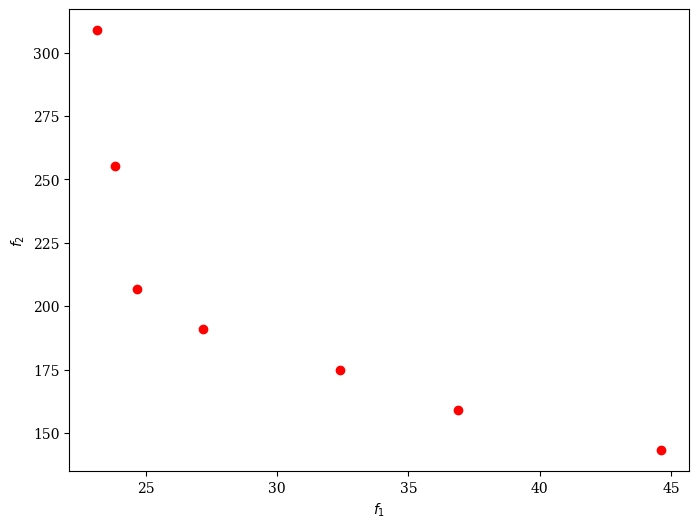

In [12]:
plot = Scatter()
plot.add(RBDOproblem.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(RBDOres.F, facecolor="red", edgecolor="red")
plot.show()
plt.savefig(pareto_fig_name)

In [13]:
RBDOres.F

array([[ 36.88316087, 159.04312809],
       [ 23.83688946, 255.2544031 ],
       [ 44.6244461 , 143.13881528],
       [ 27.17477865, 190.85175371],
       [ 32.40105308, 174.9474409 ],
       [ 23.15780083, 308.85782776],
       [ 24.66536421, 206.75606651]])

In [14]:
RBDOres.X

array([{'nfw': 5, 'nff': 5, 'dfw': 4.5, 't': 0.6968330098429399},
       {'nfw': 8, 'nff': 5, 'dfw': 5.0, 't': 0.3948063186397646},
       {'nfw': 4, 'nff': 5, 'dfw': 4.5, 't': 0.8610670745686823},
       {'nfw': 7, 'nff': 5, 'dfw': 4.5, 't': 0.48662196687091597},
       {'nfw': 6, 'nff': 5, 'dfw': 4.5, 't': 0.5993053168265873},
       {'nfw': 8, 'nff': 5, 'dfw': 5.5, 't': 0.3613475872907594},
       {'nfw': 8, 'nff': 5, 'dfw': 4.5, 't': 0.42950307048652353}],
      dtype=object)

# File Management Section:

In [15]:
import os
 
def create_file(filename):
    try:
        with open(filename, 'w') as f:
            f.write('Hello, world!\n')
        print("File " + filename + " created successfully.")
    except IOError:
        print("Error: could not create file " + filename)

In [16]:

create_file(filename)

def save_value(input_value, filename):
    with open(filename, "w") as f:    
        f.write(input_value)
        f.close()
        
def append_value(input_value, filename):
    with open(filename, "a") as f:    
        f.write(input_value)
        f.close()

def load_value(filename):
    with open(filename, "r") as f:
        read = f.read()
    return read

save_value("\n----------------------\n", filename)
append_value("threshold: "+str(threshold)+"\n", filename)
append_value("f1f2 results: \n"+str(RBDOres.F), filename)

append_value("\n----------------------\n", filename)
append_value("x results: \n"+str(RBDOres.X), filename)

append_value("\n----------------------\n", filename)
append_value("G constraints: "+str(RBDOres.G), filename)

append_value("\n----------------------\n", filename)
append_value("Load case Fx, Fy = "+str([Fx_inp, Fy_inp])+"\n", filename)
append_value("cov_load & cov_all = "+str([cov_load, cov_all]), filename)


append_value("\n----------------------\n", filename)
append_value("Fixed design parameters:\n", filename)
append_value("length = "+str([length])+"\n", filename)
append_value("web & foot_height = "+str([web_height, foot_height])+"\n", filename)
append_value("rho = "+str([density])+"\n", filename)

append_value("\n----------------------\n", filename)
append_value("bearing_allowables_clip_frame_fuselage = "+str(flat_ext_bearing_allowables_clip_frame_fuselage)+"\n", filename)
append_value("shear_allowables_bolt = "+str(flat_ext_shear_allowables_bolt)+"\n", filename)
append_value("tension_allowables_bolt = "+str(flat_ext_tension_allowables_bolt)+"\n", filename)

append_value("\n----------------------\n", filename)
append_value('B-basis of clip bearing allowable = '+str(B_val_clip)+"\n", filename)
append_value('B-basis of bolt shear allowable = '+str(B_val_bolt_shear)+"\n", filename)
append_value('B-basis of bolt tension allowable = '+str(B_val_bolt_tension)+"\n", filename)

append_value("bolt stiffness = "+str([bolt_K])+"\n", filename)
append_value("tp2, tp3 = "+str([t_p2, t_p3])+"\n", filename)
append_value("\n----------------------\n", filename)

append_value("optimization design variables catalogues: \n"+"nfw, dfw, nff \n"+str([l_nfw, l_dfw, l_nff])+"\n", filename)
append_value("NSGA settings: pop_size & n_gen = "+str([pop_size, n_gen])+"\n", filename)
append_value("\n----------------------\n", filename)

append_value("MCS sample size = "+str(10000)+"\n", filename)

File Fx1k_Fy4k_Parallel_RBDO_P-0.005_pop100.txt created successfully.
